In [312]:
#Import Modules
import glob
import os
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.style as style
from sklearn.preprocessing import MultiLabelBinarizer
import tensorflow_hub as hub
from tensorflow.keras import layers
import tensorflow_addons as tfa
from datetime import datetime
from tensorflow.keras.preprocessing import image
from PIL import Image
import numpy as np 

c:\users\christian's pc\appdata\local\programs\python\python39\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


### Read In Data ###

In [2]:
### Declare Filepaths ###:
property_csv_path = ''
training_images_path = ''
model_outpath = ''

In [3]:
## import properties.csv as df
properties_df = pd.read_csv(property_csv_path)


In [4]:
#Optional: Inspect header of dataframe
properties_df.head()

,property_id,displayPrice,dateSold,tenure,newBuild,address,propertyType,bedrooms,detailUrl,location_lat,...,pano_id,heading,pitch,fov,probability,best_image_dir,east_probability,west_probability,south_probability,good_image
0,88d39487-1557-4dcb-8222-e5cc6e9494c6,"£95,000",2023-01-20,Leasehold,False,"62, Exeter Street, St Helens, Merseyside WA10 4HR",Terraced,2.0,https://www.rightmove.co.uk/house-prices/detai...,53.45342,...,d16VqXDFzToaCBo3N-XnKQ,90,10,90,3.315015e-14,test_east_images,0.999894,NaN,NaN,1
1,61afcb29-ad01-4141-9326-c706e2f7b137,"£435,435",2023-03-27,NaN,False,"35, Porterfield Crescent, Penicuik, Midlothian...",Unknown,NaN,https://www.rightmove.co.uk/house-prices/detai...,55.84380,...,YdRNSPnkgE1Svj9IRZTFCw,90,10,90,5.431294e-14,test_east_images,0.999989,NaN,NaN,1
2,1ac6fee2-8850-4efd-9488-111b2728556e,"£215,000",2023-03-27,NaN,False,"14, Porterfield Crescent, Penicuik, Midlothian...",Unknown,NaN,https://www.rightmove.co.uk/house-prices/detai...,55.84380,...,YdRNSPnkgE1Svj9IRZTFCw,90,10,90,5.431294e-14,test_east_images,0.999989,NaN,NaN,1
3,4125cf0e-31c9-4858-8d9b-2f4c0fb58161,"£80,000",2023-01-10,Freehold,False,"11, Aylesbury Street, Keighley, West Yorkshire...",Terraced,2.0,https://www.rightmove.co.uk/house-prices/detai...,53.85485,...,sSmmbIyFuwkdSl_fCjTgCg,90,10,90,7.635143e-13,test_east_images,0.983403,NaN,NaN,1
4,c1935e2f-efd3-47d7-a058-6a1fbfeb2f5c,"£205,000",2023-02-16,NaN,False,"39, Hawkins Terrace, Penicuik, Midlothian EH26...",Unknown,2.0,https://www.rightmove.co.uk/house-prices/detai...,55.84484,...,mqXP1NEzu99rsMhvQtbi4w,90,10,90,6.700315e-12,test_east_images,1.000000,NaN,NaN,1


In [5]:
### Generate Df of Filepaths with Property ID ###

training_images_path_glob = training_images_path + '\*'

files_raw = glob.glob(training_images_path_glob)

path_clean = []
name_clean = [] 

for file in files_raw:
    path_clean.append(file.split('\\')[-1])
    name_clean.append(file.split('\\')[-1].split('_')[-1].strip('.jpg'))
    
d = {'paths':path_clean, 'property_id':name_clean}

img_df = pd.DataFrame(d)


In [6]:
#Optional: Inspect header of dataframe
img_df.head()

,paths,property_id
0,gsv_0007cf27-080d-42d1-b080-7d99cca29e0b.jpg,0007cf27-080d-42d1-b080-7d99cca29e0b
1,gsv_000ee911-56d2-4917-9152-05aab09db2cd.jpg,000ee911-56d2-4917-9152-05aab09db2cd
2,gsv_0011fa14-f039-47f9-9624-d6f6f8f12f99.jpg,0011fa14-f039-47f9-9624-d6f6f8f12f99
3,gsv_0023721c-3fe5-410d-ab4e-7fb2c44c31a2.jpg,0023721c-3fe5-410d-ab4e-7fb2c44c31a2
4,gsv_002b8f0f-0a2b-47b2-9fbb-6e160f56ff58.jpg,002b8f0f-0a2b-47b2-9fbb-6e160f56ff58


In [7]:
###Merge Two Dfs using inner join
merged_df = img_df.merge(properties_df, how = 'inner', on = ['property_id'])
merged_df = merged_df[merged_df['propertyType'] != 'Unknown']

In [8]:
#Optional: check count of Property Types we have
merged_df.groupby('propertyType')['propertyType'].count()

propertyType
Detached         205
Flat             119
Semi-Detached    323
Terraced         353
Name: propertyType, dtype: int64

### Split into Test and Train Sets ###

In [9]:
#Split into Training and Test Sets
X_train, X_val, y_train, y_val = train_test_split(merged_df['paths'], merged_df['propertyType'], test_size=0.2, random_state=13)

print("Training Samples: ", len(X_train))
print("Validation Samples: ", len(X_val))

Training Samples:  800
Validation Samples:  200


In [10]:
#Create list of File Paths for reading training and validaiton images
X_train = [os.path.join(training_images_path, str(f)) for f in X_train]
X_val = [os.path.join(training_images_path, str(f)) for f in X_val]

In [11]:
#Function to convert to list of lists
def convert_to_list_of_lists(list_object):
    results = []
    for thing in list_object:
        results.append([thing])
    return results

In [12]:
#Create list of lists objects for response labels
y_train = list(y_train)
y_train = convert_to_list_of_lists(y_train)
y_val = list(y_val)
y_val = convert_to_list_of_lists(y_val)
y_train[:3]

[['Terraced'], ['Semi-Detached'], ['Terraced']]

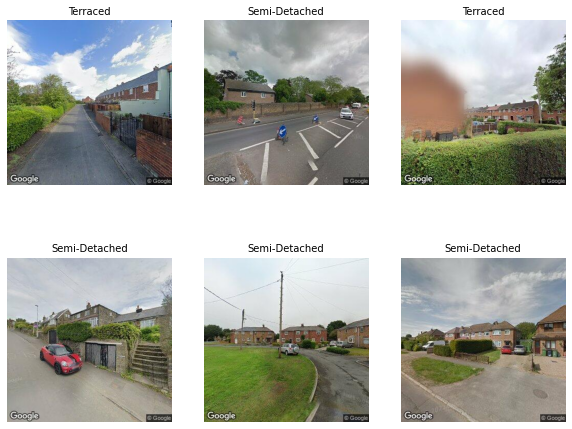

In [14]:
#Plot Images

ncols = 3 
nrows = 2 

plt.figure(figsize=(10,4*nrows))
for i in range(nrows*ncols):
    ax = plt.subplot(nrows, ncols, i+1)
    plt.imshow(Image.open(X_train[i]))
    plt.title(y_train[i][0], size=10)
    plt.axis('off')

In [155]:
# Fit the multi-label binarizer on the training set
mlb = MultiLabelBinarizer()
mlb.fit(y_train)

# Loop over all labels and show them
N_LABELS = len(mlb.classes_)

print("Labels:")

for (i, label) in enumerate(mlb.classes_):
    print("{}. {}".format(i, label))

Labels:
0. Detached
1. Flat
2. Semi-Detached
3. Terraced


In [16]:
#make response vectors for each image
y_train_bin = mlb.transform(y_train)
y_val_bin = mlb.transform(y_val)

### DONE with PREPROCESSING ###

### Do Multi Label Process But Modify ###

In [17]:
IMG_SIZE = 224 
CHANNELS = 3 

In [18]:
def parse_function(filename, label):
    """Function that returns a tuple of normalized image array and labels array.
    Args:
        filename: string representing path to image
        label: 0/1 one-dimensional array of size N_LABELS
    """
    # Read an image from a file
    image_string = tf.io.read_file(filename)
    
    # Decode it into a dense vector
    image_decoded = tf.image.decode_jpeg(image_string, channels=CHANNELS)
    
    image_resized = tf.image.resize(image_decoded, [IMG_SIZE, IMG_SIZE])
    
    image_normalized = image_resized / 255.0
    return image_normalized, label

In [19]:
BATCH_SIZE = 400
AUTOTUNE = tf.data.experimental.AUTOTUNE # Adapt preprocessing and prefetching dynamically
SHUFFLE_BUFFER_SIZE = 400

In [20]:
def create_dataset(filenames, labels, is_training=True):
    """Load and parse dataset.
    Args:
        filenames: list of image paths
        labels: numpy array of shape (BATCH_SIZE, N_LABELS)
        is_training: boolean to indicate training mode
    """
    
    # Create a first dataset of file paths and labels
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    
    # Parse and preprocess observations in parallel
    dataset = dataset.map(parse_function, num_parallel_calls=AUTOTUNE)
    
    if is_training == True:
        dataset = dataset.cache()
        dataset = dataset.shuffle(buffer_size=SHUFFLE_BUFFER_SIZE)
        
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    
    return dataset

In [21]:
train_ds = create_dataset(X_train, y_train_bin)
val_ds = create_dataset(X_val, y_val_bin)

In [22]:
for f, l in train_ds.take(1):
    print("Shape of features array:", f.numpy().shape)
    print("Shape of labels array:", l.numpy().shape)

Shape of features array: (400, 224, 224, 3)
Shape of labels array: (400, 4)


In [23]:
feature_extractor_url = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b0/classification/2"
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=(IMG_SIZE,IMG_SIZE,CHANNELS),
                                         trainable = True)



In [24]:
LR = 1e-4 # Keep it small when transfer learning
EPOCHS = 15

In [25]:
model_bce = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    feature_extractor_layer,
    layers.Dense(N_LABELS, activation='softmax')])

model_bce.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate= LR),
    loss=tf.keras.metrics.categorical_crossentropy,
    metrics=['accuracy'])
    
history_bce = model_bce.fit(train_ds,
                            epochs=EPOCHS,
                            validation_data=create_dataset(X_val, y_val_bin))


Epoch 1/15
2/2 [==============================] - 277s 129s/step - loss: 2.4120 - accuracy: 0.2562 - val_loss: 2.2772 - val_accuracy: 0.3700
Epoch 2/15
2/2 [==============================] - 296s 147s/step - loss: 1.9848 - accuracy: 0.3450 - val_loss: 2.2131 - val_accuracy: 0.3900
Epoch 3/15
2/2 [==============================] - 286s 147s/step - loss: 1.6977 - accuracy: 0.4150 - val_loss: 1.9223 - val_accuracy: 0.4100
Epoch 4/15
2/2 [==============================] - 277s 132s/step - loss: 1.4469 - accuracy: 0.4700 - val_loss: 1.7321 - val_accuracy: 0.4200
Epoch 5/15
2/2 [==============================] - 298s 155s/step - loss: 1.2376 - accuracy: 0.5088 - val_loss: 1.6323 - val_accuracy: 0.4300
Epoch 6/15
2/2 [==============================] - 282s 153s/step - loss: 1.1221 - accuracy: 0.5450 - val_loss: 1.5708 - val_accuracy: 0.4250
Epoch 7/15
2/2 [==============================] - 273s 141s/step - loss: 1.0109 - accuracy: 0.5838 - val_loss: 1.5283 - val_accuracy: 0.4400
Epoch 8/15
2/

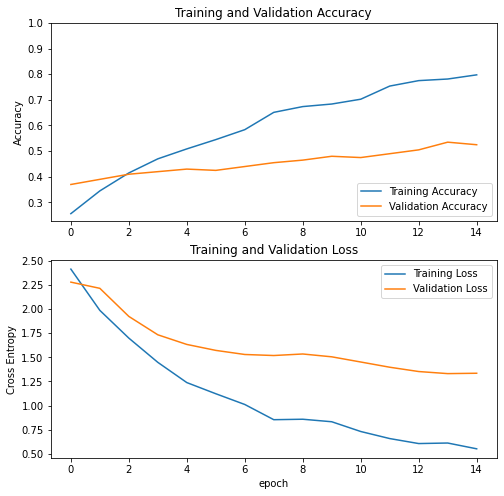

In [26]:
acc = history_bce.history['accuracy']
val_acc = history_bce.history['val_accuracy']

loss = history_bce.history['loss']
val_loss = history_bce.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
#plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [280]:
def show_prediction(image_idx, X_val, y_val, model_bce):
    
    # Get image path
    img_path = X_val[image_idx]
    
    # Read and prepare image
    img = image.load_img(img_path, target_size=(IMG_SIZE,IMG_SIZE,CHANNELS))
    img = image.img_to_array(img)
    img = img/255
    img = np.expand_dims(img, axis=0)

    # Generate prediction
    prediction = model_bce.predict(img)
    prediction = pd.Series(prediction.flatten())
    prediction.index = mlb.classes_
    prediction_max = prediction.max()
    prediction = prediction.index[prediction.argmax()]

    # Dispaly image with prediction
    style.use('default')
    plt.figure(figsize=(8,4))
    plt.imshow(Image.open(img_path))
    plt.title('\nPrediction\n{}\nTrue Answer: {}'.format(prediction, y_val[image_idx][0]), fontsize=9)
    plt.show()

1/1 [==============================] - 0s 44ms/step


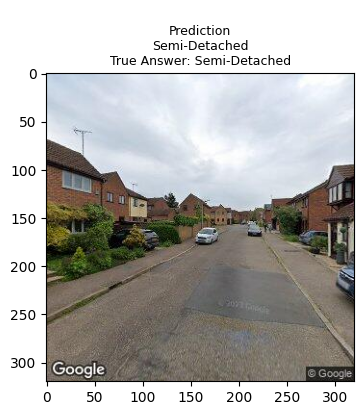

1/1 [==============================] - 0s 38ms/step


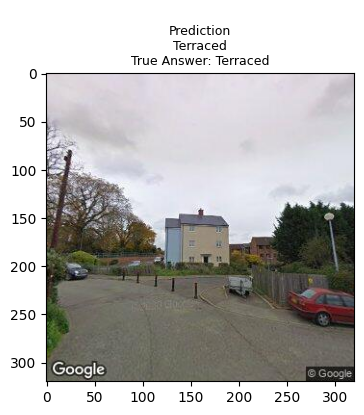

1/1 [==============================] - 0s 28ms/step


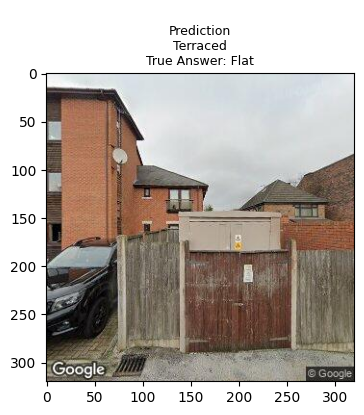

1/1 [==============================] - 0s 40ms/step


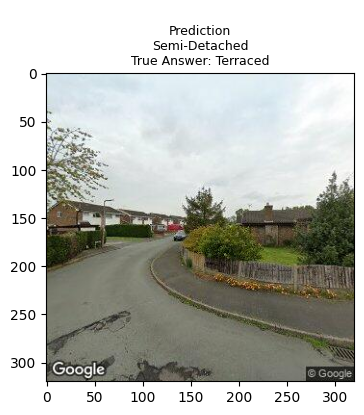

1/1 [==============================] - 0s 42ms/step


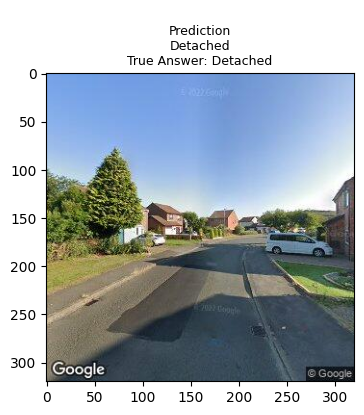

In [281]:
image_indexes = [1, 2, 3, 4, 5]

for img_idx in image_indexes:
    show_prediction(img_idx, X_val, y_val, model_bce)

In [282]:
def model_accuracy(X_val, y_val, model_bce):
    
    # Get image path
    correct_count = 0
    count = 0 
    
    for img_path in X_val:
    
        # Read and prepare image
        img = image.load_img(img_path, target_size=(IMG_SIZE,IMG_SIZE,CHANNELS))
        img = image.img_to_array(img)
        img = img/255
        img = np.expand_dims(img, axis=0)

        # Generate prediction
        prediction = model_bce.predict(img)
        prediction = pd.Series(prediction.flatten())
        prediction.index = mlb.classes_
        prediction_max = prediction.max()
        prediction = prediction.index[prediction.argmax()]
        
        if prediction == None:
            pass
        
        elif prediction == y_val[count][0]:
            correct_count +=1
        
        count += 1
            
    return correct_count/len(X_val)

In [283]:
accuracy = model_accuracy(X_val, y_val, model_bce)


1/1 [==============================] - 0s 31ms/step


In [284]:
accuracy

0.48

In [323]:
def calculate_f1_score(X_val, y_val_bin, model_bce):
    
    # make empty array of right shape
    pred_array = np.empty((1,4))
    
    for img_path in X_val:
    
        # Read and prepare image
        img = image.load_img(img_path, target_size=(IMG_SIZE,IMG_SIZE,CHANNELS))
        img = image.img_to_array(img)
        img = img/255
        img = np.expand_dims(img, axis=0)

        # Generate prediction
        prediction = model_bce.predict(img)
        prediction = pd.Series(prediction.flatten())
        prediction.index = mlb.classes_
        
        #generate prediciton array 
        m = np.zeros_like(prediction.values)
        m[prediction.argmax()] = 1
        m = m.reshape(1,4)
        
        
        #append array
        pred_array = np.append(pred_array, m, axis = 0)
    
    #remove first item from pred array
    pred_array = np.delete(pred_array, 0, axis = 0)
    
    #calculate f1 score 
    f1_metric = tfa.metrics.F1Score(num_classes=4, threshold= None)
    f1_metric.update_state(y_val_bin, pred_array)
    f1_result = metric.result()
    
    return f1_result 


In [326]:
f1_score = calculate_f1_score(X_val, y_val_bin, model_bce)
f1_score

1/1 [==============================] - 0s 58ms/step


<tf.Tensor: shape=(4,), dtype=float32, numpy=array([0.43478262, 0.18181817, 0.55214727, 0.48888892], dtype=float32)>

## Save Model ##

In [325]:
model_bce.save(model_outpath)
